# Programming Exercise 5: Regularized Linear Regression and Bias vs. Variance

Welcome to programming exercise 5, Regularized Linear Regression and Bias vs. Variance. In this exercise, we will implement regularized linear regression and use it to study models with different bias-variance properties.

**Instruction:**
- To run code, click on a corresponding cell and press `Shift+Enter` keys simultaneously or Click `Cell -> Run Cell`.

**Objective:**
- To implement regularized linear regression and use it to understand various bias-vs-variance properties of the model.

**You will learn how to:**
- Implement regularized linear 
- trade-off between bias and variance model properties

## Import packages ##

First lets run the cell below to import all the packages that you will need for this exercise.
- [NumPy](http://www.numpy.org) is the fundamental package for scientific computing with Python
- [Matplotlib](http://matplotlib.org) is a common library to plot graphs in python.
- [Scipy](https://docs.scipy.org/doc/scipy-0.17.0/reference/optimize.html) a python library for optimization functions.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import scipy.io as sio

# For optimization
from scipy import optimize as opt

# For data plots and visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

%load_ext autoreload
%autoreload 2

## 1 - Regularized Linear Regression

In the frst half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias vs. variance.

### 1.1 - Loading and visualizing the dataset ###

We will begin by visualizing the dataset containing historical records on the change in the water level, ${x}$, and the amount of water flowing out of the dam, ${y}$.

This dataset is divided into three parts:

- A training set that your model will learn on: X, y
- A cross validation set for determining the regularization parameter: Xval, yval
- A test set for evaluating performance. These are \unseen" examples which your model did not see during training: Xtest, ytest

**In the cell below, we load dataset into various variables**

In [2]:
df_path = 'data/ex5data1.mat'
data = sio.loadmat(df_path)
X_train, y_train, X_test, y_test, X_val, y_val = data['X'], data['y'], data['Xtest'], data['ytest'], data['Xval'],data['yval']

After loading the dataset, we can now define a function that we shall use to visualize the training data; `x_train`,`y_ytrain`.

In [3]:
def plotData(x,y):
    plt.plot(x,y,'rx',markersize=10, label='Training Example')
    plt.grid(True) #Always plot.grid
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water levels (x)')
    plt.title('Figure 1: Training Examples')
    plt.axis([-50, 40, -5, 40])
    plt.legend()

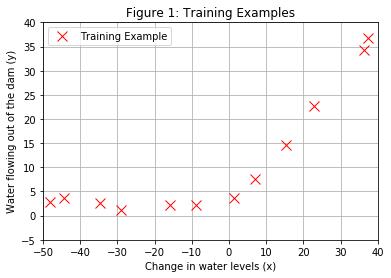

In [4]:
plotData(X_train,y_train) # calling the plotData() fucntion

### 1.2 - Regularized linear regression cost function##

Recall that regularized linear regression has the following cost function:

![reg_linear_cost_function](images/reg_linear_cf.png)

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overal cost ${J{(\theta)}}$.

This means as the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. It should be noted that we do not regularize the $\theta_0$ term.

Before we implement the regularized cost function, let us first implement the hypothesis function given by: $h_\theta {(x)} = {X\theta}$.

In [5]:
#PREDICTION FUNCTION FOR THE HYPOTHESIS
def hypothesisFunction(x, theta):
    return np.dot(x,theta)

Now we can implement the regularized linear cost function..

In [6]:
def linearRegCostFunction(x, y, theta,Lambda):
    m = x.shape[0]; # number of training examples
    h = hypothesisFunction(x,theta) # (12,2).(2,1) =(12,1)
    error = h-y;
    error_sqrd = np.square(error);
    sum_error_sqrd = np.sum(error_sqrd) 
    unreg_cost =(1/(2*m)) * sum_error_sqrd;
    temp = np.ones((theta.shape[0],1))
    temp[0,0] = 0
    reg_term = (Lambda/(2*m)) * np.sum(np.square(np.multiply(temp, theta)))
    cost = unreg_cost + reg_term
    return cost

We can evaluate our cost function by first adding a column of ones to the input data X_train.

In [7]:
X = np.insert(X_train,0,1,axis=1)  #ADD A COLUMN OF ONES TO X (FOR X0 = 1) 
Xval = np.insert(X_val,0,1,axis=1) #ADD A COLUMN OF ONES TO Xval (FOR X0 = 1)
(m,n) = X.shape #Shape of X after adding a column of ones
theta_test =np.array([[1],[1]]) # THETA IS OF (2,1) DIMENSION
print('The shape of X is :', X.shape);

The shape of X is : (12, 2)


In [8]:
cost = linearRegCostFunction(X, y_train, theta_test, Lambda=1)
print('\nComputed cost at theta [[1],[1]]: %6f '% (cost));


Computed cost at theta [[1],[1]]: 303.993192 


### 1.3 - Regularized gradient function ##

Correspondingly, the partial derivative of regularized linear regression's cost for ${J{(\theta)}}$ is defined as:

![reg_gradient_fucntion](images/reg_gradient_function.png)

We now implement the gradient function, `linearRegGradientFunction()`...

In [9]:
def linearRegGradientFunction(x, y, theta,Lambda):
    m = x.shape[0];# # number of training examples
    h = np.dot(x,theta); # (12,1)
    error = h - y; #(12,1)
    unreg_grad = (1/m) * np.dot(x.T,error); # (2,12).(12,1) = (2,1)
    temp = np.ones((theta.shape[0],1))
    temp[0,0] = 0.0
    reg_term = (Lambda/m) * np.multiply(temp,theta)
    grad = unreg_grad + reg_term
    return grad

Like the cost function, let us evaluate the gradient function we just implemented at theta [[1],[1]].

In [10]:
grad = linearRegGradientFunction(X, y_train, theta_test,Lambda=1);
print('\nGradient at theta [[1],[1]]:',str(grad[:,0]) +'\n')


Gradient at theta [[1],[1]]: [-15.30301567 598.25074417]



### 1.4 - Fitting linear regression ##

Now that our cost function and gradient are working correctly, we need to implement a `trainLinearReg()` to compute the optimal values $\Theta$. This training function uses `fmin_cg` to optimize the cost function.

In this part, we set regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension.

In [11]:
def trainLinearReg(x, y, Lambda):
    
    # initialize Theta
    initial_theta = np.zeros((x.shape[1], 1))
    
    # create cost and grad functions
    cost = lambda t: linearRegCostFunction(x, y, t.reshape(-1,1), Lambda)
    grad = lambda t: linearRegGradientFunction(x, y, t.reshape(-1,1), Lambda).flatten()
    
    # minimize using fmincg
    theta = opt.fmin_cg(cost, initial_theta.T, fprime=grad, maxiter=200, disp=False)

    return theta.reshape(-1,1)

In [12]:
theta = trainLinearReg(X, y_train, Lambda=0);
print('Computed theta :\n %s '% (str(theta)))

Computed theta :
 [[13.08790351]
 [ 0.36777923]] 


Finally, based on the computed theta values, we can plot the best fit line. The best fit line tells us that the model is
not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as plotted is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model.

In [13]:
def plotLinearFit(x,y,h):
    fig, ax = plt.subplots()
    ax.plot(x,y,'rx',markersize=10, label='Training Example')
    ax.plot(x,h,'b-',label = 'Hypothesis: h(x) = %0.2f + %0.2fx'%(theta[0],theta[1]))
    ax.grid(True)
    ax.set_ylabel('Water flowing out of the dam (y)')
    ax.set_xlabel('Change in water levels (x)')
    titlestr = 'Hypothesis Function: Y = %.2f + %.2fX' % (theta[0], theta[1])
    plt.title(titlestr)
    plt.legend()
    plt.axis([-50, 40, -5, 40])
    plt.show()

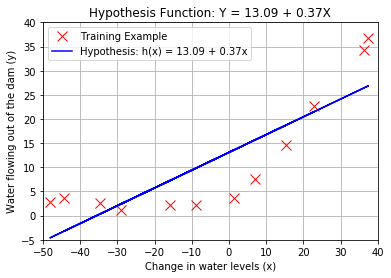

In [14]:
h = hypothesisFunction(X,theta)
plotLinearFit(X_train, y_train,h)

## Part 2: Bias - Variance Trade-Off

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

### 2.1 - Learning curves ###

We will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set X.

Specifically, for a training set size of i, you should use the first i examples (i.e., X[:i, :] and y[1:i]).

We use the `trainLinearReg()` to compute the $\theta$ parameters. It should be noted that:

- the $\lambda$ is passed as a parameter to the `learningCurve()` function.
- After learning the $\theta$ parameters, you should compute the error on the training and cross validation sets.

Recall that the training error for a dataset is defined as:
![training_error](images/training_error.png)

In particular, note that the training error does not include the regularization term. Therefore, one way to compute the training error is to use your existing cost function and set $\lambda$ to zero (0) only when using it to compute the training error and cross validation error.

When we are computing the training set error, we make sure we compute it on the training subset (i.e., X[1:n,:] and y[1:n])
(instead of the entire training set). However, for the cross validation error, we should compute it over the entire cross validation set. Then, we should store the computed errors in the vectors `error train` and `error val`.

In [15]:
def learningCurve(Xtrain, ytrain, Xval, yval, Lambda):
    
    m = Xtrain.shape[0]
    
    # You need to return these values correctly
    error_train = np.zeros((m, 1));
    error_val   = np.zeros((m, 1));
    
    for i, j in enumerate(range(1,m+1)):
        theta = trainLinearReg(Xtrain[0:j,:], ytrain[:j,:], Lambda);
        error_train[i] = linearRegCostFunction(Xtrain[:j,:], ytrain[:j,:], theta, 0);
        error_val[i] = linearRegCostFunction(Xval, yval, theta, 0);
    return error_train, error_val

In [16]:
error_train, error_val = learningCurve(X, y_train, Xval, y_val, Lambda=0)

print('# Training Examples\tTrain Error\tCross Validation Error\n');
for i in range(0, m):
    print('  \t%d\t\t%f\t%f\n' % (i+1, error_train[i], error_val[i]));


# Training Examples	Train Error	Cross Validation Error

  	1		0.000000	205.121096

  	2		0.000000	110.300366

  	3		3.286595	45.010232

  	4		2.842678	48.368911

  	5		13.154049	35.865141

  	6		19.443963	33.829957

  	7		20.098522	31.970987

  	8		18.172859	30.862446

  	9		22.609405	31.135998

  	10		23.261462	28.936207

  	11		24.317250	29.551432

  	12		22.373906	29.433818




 Plotting the Learning curves for Linear Regression ... 



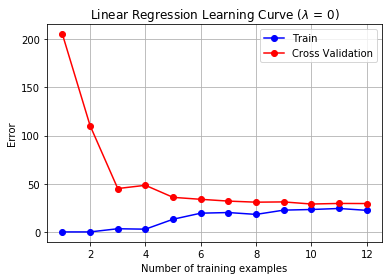

In [17]:
print('\n Plotting the Learning curves for Linear Regression ... \n')
plt.plot(range(1,m+1),error_train,'b-o', label='Train')
plt.plot(range(1,m+1),error_val,'r-o', label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Linear Regression Learning Curve (%s = %d)' % (r'$\lambda$',0));
plt.legend()
plt.grid(True)
plt.show()

It can be observed that both the train error and cross validation error are high when the number of training examples is increased. This reflects a `high bias` problem in the model - the linear regression model is too simple and is unable to fit our dataset well.

## Part 3 - Polynomial regression ##

In the this section, we will attempt to implement polynomial regression to fit a better model for this dataset.

The problem with our linear model was that it was too simple for the data and resulted in `underfitting (high bias)`. In this part of the exercise, you will address this problem by adding more features.

For use polynomial regression, our hypothesis has the form:
![polynomial_reg](images/polynomial_reg.png)

Notice that by defining ${x_1} = {(waterLevel)}$, ${x_2} = {(waterLevel)^2}$, ..., ${x_p} = {(waterLevel)^p}$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel). Now, you will add more features using the higher powers of the existing feature x in the dataset.

Our task is to implement a function `polyFeatures()` so that the function maps the original training set X of size
mx1 into its higher powers. Specifically, when a training set X of size mx1 is passed into the function, the function should return a mxp matrix `X_poly`, where column 1 holds the original values of X, column 2 holds the values of ${X^2}$, column 3 holds the values of ${X^3}$, and so on. Note that you don't have to account for the zero-eth power in this function.

In [18]:
def polyFeatures(x, p):
    X_poly = np.zeros((x.size, p)) # We need X_poly to be of dimension (m,p)
    X_poly[:,0] = x[:,0] # We set the first column of the X_poly to be the column vector of X.
    for i in range(1,p):
        X_poly[:,i] = np.power(x[:,0],i+1); 
    return X_poly

### 3.1 - Learning Polynomial Regression###

After completing `polyFeatures()` function, will proceed to train polynomial regression using our already defined linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that we wrote for the earlier part of this exercise.

For this part of the exercise, we will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with x = 40 will now have a feature $x^8 = 408 = 6.5 x 10^{12}$). Therefore, we will need to use `feature normalization`.

This means that before learning the parameters $\theta$ for the polynomial regression, we will need to first implement a function `featureNormalize()` and normalize the features of the training set, storing the mean $\mu$, standard deviation $\sigma$ parameters separately

In [19]:
'''
def featureNormalize(x, mu=None, sigma=None):
    if mu is None:
        mu = np.mean(x, axis = 0);
    if sigma is None:
        sigma = np.std(x, ddof=1, axis = 0);
    
    x_norm = (x - mu)/sigma
    return x_norm, mu, sigma
'''
def featureNormalize(x):
    # Computing the Mean and STD of x
    mu = np.mean(x, axis=0, keepdims=True);
    sigma = np.std(x,ddof=1, axis = 0, keepdims=True);
    # Normalize X 
    X_norm = (x - mu)/sigma
    return X_norm, mu, sigma

Now we can find polynomial expressions of the `X_train`, `X_val` and `X_test` for the polynomial degree of 8.

In [20]:
print('\n===========================================================================')
print('# Map X_train onto Polynomial Features and Normalize')
print('===========================================================================')
X_poly_train = polyFeatures(X_train, p=8)
X_poly_train, mu_train, sigma_train = featureNormalize(X_poly_train)
X_poly_train = np.insert(X_poly_train,0,1,axis=1) #Add one the X_poly_train
print('\nThe dimension of X_poly_train is ' + str(X_poly_train.shape)+'\n')
print('Normalized Training Example 1:\n', X_poly_train[0, :]);
print('\n===========================================================================')
print('# Map Xval onto Polynomial Features and Normalize(using mu_train and sigma_train)')
print('===========================================================================')
X_poly_val = polyFeatures(X_val, p=8);
X_poly_val = (X_poly_val - mu_train)/sigma_train
X_poly_val = np.insert(X_poly_val,0,1,axis=1) #Add one the X_poly_val
print('\nThe dimension of X_poly_val is ' + str(X_poly_val.shape)+ '\n')
print('Normalized Validation Example 1:\n', X_poly_val[0, :]);
print('\n===========================================================================')
print('# Map Xtest onto Polynomial Features and Normalize(using mu_train and sigma_train)')
print('===========================================================================')
X_poly_test = polyFeatures(X_test, p=8);
X_poly_test = (X_poly_test - mu_train)/sigma_train
X_poly_test = np.insert(X_poly_test,0,1,axis=1) #Add one the X_poly_test
print('\nThe dimension of X_poly_test is ' + str(X_poly_test.shape)+ '\n')
print('Normalized Test Example 1:\n', X_poly_test[0, :]);
print('\n==================================== DONE =================================')


# Map X_train onto Polynomial Features and Normalize

The dimension of X_poly_train is (12, 9)

Normalized Training Example 1:
 [ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]

# Map Xval onto Polynomial Features and Normalize(using mu_train and sigma_train)

The dimension of X_poly_val is (21, 9)

Normalized Validation Example 1:
 [ 1.         -0.38916543 -0.72149541  0.16876064 -0.69803716  0.30354037
 -0.58940525  0.34396872 -0.50824813]

# Map Xtest onto Polynomial Features and Normalize(using mu_train and sigma_train)

The dimension of X_poly_test is (21, 9)

Normalized Test Example 1:
 [ 1.         -0.94220394  0.33149914 -0.50128942 -0.03307354 -0.11950565
 -0.24013304  0.11556833 -0.33419137]

==================================== DONE =================================


The function `plotFit()` below plots the polynomial regression on the sample data.

In [21]:
def plotFit(min_x, max_x, mu, sigma, theta, p):
    x = np.arange(min_x-15, max_x+25, 0.05)
    x = np.reshape(x, (len(x), 1))

    # Map the X values 
    x_poly_train = polyFeatures(x, p);
    #x_poly_train, _ , _ = featureNormalize(x_poly_train)
    x_poly_train = (x_poly_train - mu)/sigma;
    #x_poly_train = x_poly_train/sigma;
    x_poly_train = np.insert(x_poly_train,0,1,axis=1)

    # Plot the polynomial regression
    h = hypothesisFunction(x_poly_train, theta)
    plt.plot(x, h, 'b--')

At this tage of the exercise, we can now evaluate our implementations. So far we have implemented:
- `polyFeatures()` for mapping feature input featurs onto polynomial features with a specified degree.
- `featureNormalize(x)` for normalizing the resultant polynomial features
- `plotFit()` for plotting and fitting polynomial regression

Let us begin by first learning the parameters $\theta$ for polynomial regression with $\lambda = 0$

In [22]:
# Fit the polynomial Features
theta = trainLinearReg(X_poly_train, y_train, Lambda=0);
error_train, error_val = learningCurve(X_poly_train, y_train, X_poly_val, y_val, Lambda=0);
print('# Training Examples\tTrain Error\tCross Validation Error\n');
for i in range(0, m):
    print('  \t%d\t\t%f\t%f\n' % (i+1, error_train[i], error_val[i]));

# Training Examples	Train Error	Cross Validation Error

  	1		0.000000	160.721900

  	2		0.000000	160.121510

  	3		0.000000	61.755005

  	4		0.000000	61.928895

  	5		0.000000	6.598036

  	6		0.000000	10.642456

  	7		0.008644	16.627851

  	8		0.059237	7.732426

  	9		0.024436	19.564309

  	10		0.067292	9.062371

  	11		0.034405	30.950193

  	12		0.087945	8.289569



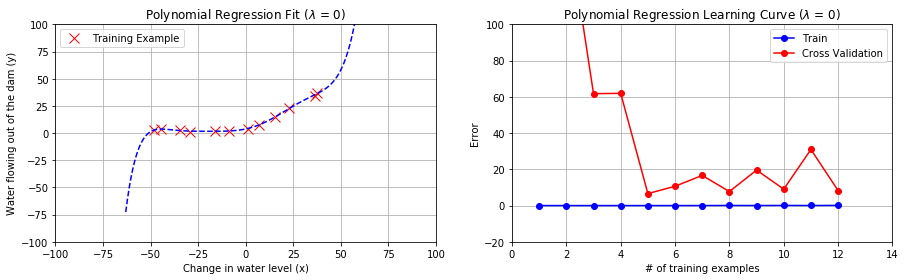

In [23]:
plt.figure(figsize=(15, 4))   

plt.subplot(1, 2, 1)
plt.plot(X_train,y_train,'rx',markersize=10, label='Training Example')
plotFit(X_train.min(), X_train.max(), mu_train, sigma_train, theta, p=8)
plt.xlabel('Change in water level (x)');
plt.ylabel('Water flowing out of the dam (y)');
titlestr = 'Polynomial Regression Fit (%s = %d)' % (r'$\lambda$',0)
plt.title(titlestr)
plt.grid(True)
plt.axis([-100,100,-100,100])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, m + 1), error_train, 'b-o', label='Train')
plt.plot(range(1, m + 1), error_val,'r-o', label='Cross Validation')
plt.xlabel('# of training examples')
plt.ylabel('Error')
plt.title('Polynomial Regression Learning Curve (%s = %d)' % (r'$\lambda$',0));
plt.grid(True)
plt.legend()
plt.axis([0,14,-20,100])
plt.show()

From the first plot above, `Polynomial Regression Fit`, we can see that the polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized ($\lambda$ = 0) model, we observe from second plot that the learning curve (on the right) shows the same effect where the low training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a `high variance` problem.

In order to combat the overfitting (high-variance) problem is to add regularization to the model. Therefore, in the next section, we will get to try different $\lambda$ parameters to see how regularization can lead to a better model.

### 3.2 - Optional (ungraded) exercise: Adjusting the regularization parameter

In this section, we will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. Our task is to  try modify and try different values of $\lambda$ - say 1 and 100. For each value, we should generate a polynomial fir and the learning curve

**3.2.1 - Regularizing with $\lambda = 1$**

In [24]:
theta = trainLinearReg(X_poly_train, y_train, Lambda=1);
error_train, error_val = learningCurve(X_poly_train, y_train, X_poly_val, y_val, Lambda=1);
print('# Training Examples\tTrain Error\tCross Validation Error\n');
for i in range(0, m):
    print('  \t%d\t\t%f\t%f\n' % (i+1, error_train[i], error_val[i]));


# Training Examples	Train Error	Cross Validation Error

  	1		0.000000	138.846777

  	2		0.045769	143.523394

  	3		2.911375	5.534713

  	4		1.499413	6.609883

  	5		1.199178	6.634112

  	6		0.924511	8.291998

  	7		1.540892	5.737148

  	8		1.422968	5.516434

  	9		1.553726	6.239793

  	10		1.441565	5.983045

  	11		1.308148	6.043763

  	12		2.076186	4.260629



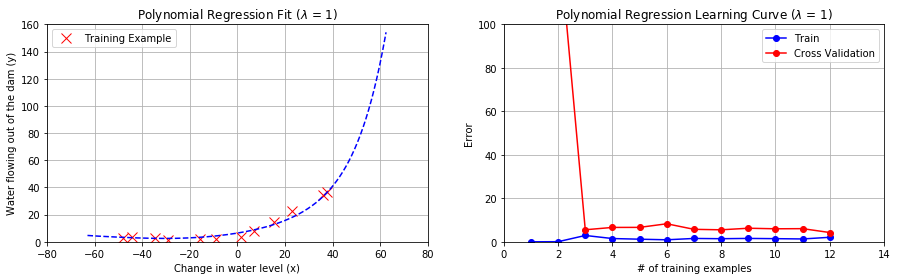

In [25]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train,y_train,'rx',markersize=10, label='Training Example')
plotFit(np.min(X_train), np.max(X_train), mu_train, sigma_train, theta, p=8)
plt.xlabel('Change in water level (x)');
plt.ylabel('Water flowing out of the dam (y)');
titlestr = 'Polynomial Regression Fit (%s = %d)' % (r'$\lambda$',1)
plt.title(titlestr)
plt.grid(True)
plt.legend()
plt.axis([-80,80,0,160])


plt.subplot(1, 2, 2)
plt.plot(range(1, m + 1), error_train, 'b-o',label='Train')
plt.plot(range(1, m + 1), error_val,'r-o', label='Cross Validation')
plt.xlabel('# of training examples')
plt.ylabel('Error')
plt.title('Polynomial Regression Learning Curve (%s = %d)' % (r'$\lambda$',1));
plt.legend()
plt.grid(True)
plt.axis([0,14,0,100])
plt.show()

For $\lambda = 1$, we can see a polynomial fit that follows the data trend well (left plot) and a learning curve (right plot) showing that both the cross validation and training error converge to a relatively low value. This shows the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

**3.2.2 - Regularizing with $\lambda = 100$**

In [26]:
theta = trainLinearReg(X_poly_train, y_train, Lambda=100);
error_train, error_val = learningCurve(X_poly_train, y_train, X_poly_val, y_val, Lambda=100);
print('# Training Examples\tTrain Error\tCross Validation Error\n');
for i in range(0, m):
    print('  \t%d\t\t%f\t%f\n' % (i+1, error_train[i], error_val[i]));

# Training Examples	Train Error	Cross Validation Error

  	1		0.000000	138.846816

  	2		0.114107	144.125231

  	3		106.956568	70.863270

  	4		121.740879	78.372963

  	5		102.949462	63.845048

  	6		97.169847	59.532626

  	7		83.326538	59.585493

  	8		76.491825	58.699842

  	9		71.297179	59.564463

  	10		64.350636	59.731344

  	11		58.997945	60.409872

  	12		57.977075	57.842190



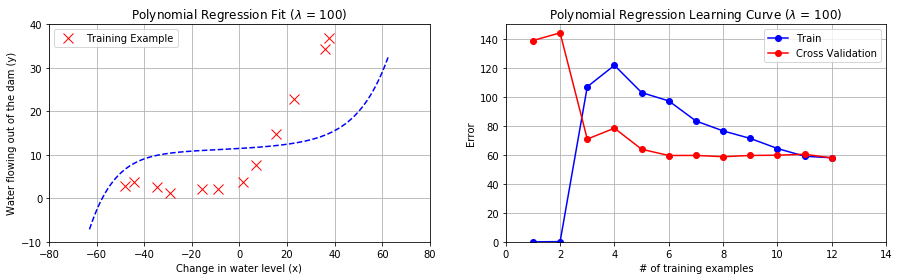

In [27]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train,y_train,'rx',markersize=10, label='Training Example')
plotFit(np.min(X_train), np.max(X_train), mu_train, sigma_train, theta, p=8)
plt.xlabel('Change in water level (x)');
plt.ylabel('Water flowing out of the dam (y)');
titlestr = 'Polynomial Regression Fit (%s = %d)' % (r'$\lambda$',100)
plt.title(titlestr)
plt.grid(True)
plt.legend()
plt.axis([-80,80,-10,40])


plt.subplot(1, 2, 2)
xvals = np.linspace(0, m, m)
plt.plot(range(1, m + 1), error_train, 'b-o',label='Train')
plt.plot(range(1, m + 1), error_val,'r-o', label='Cross Validation')
plt.xlabel('# of training examples')
plt.ylabel('Error')
plt.title('Polynomial Regression Learning Curve (%s = %d)' % (r'$\lambda$',100));
plt.legend()
plt.grid(True)
plt.axis([0,14,0,150])
plt.show()

For $\lambda = 100$, we can observe a polynomial fit (left plot) that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

### 3.3 - Selecting $\lambda$ using a cross validation set ##

From the previous parts of the exercise, we have observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regular-
ization ($\lambda = 0$) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($\lambda = 100$) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g. $\lambda = 1$) can provide a good fit to the data.

In this section, you will implement an automated method to select the $\lambda$  parameter. Concretely, you will use a cross validation set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.

Our task is to implement a function `validationCurve()` that will make use of the `trainLinearReg()` to train the model using different values $\lambda$ and compute the training error and cross validation error.

We shall attempt $\lambda$ values in the following range: (0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10).

In [28]:
def validationCurve(Xtrain, y, Xval, yval):
    
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1,3, 10]);
    
    error_train = np.zeros((len(lambda_vec), 1));
    error_val = np.zeros((len(lambda_vec), 1));
    
    for i, lambda_val in enumerate(lambda_vec):
        Lambda = lambda_vec[i];
        theta = trainLinearReg(Xtrain, y, lambda_val);
        error_train[i] = linearRegCostFunction(Xtrain, y, theta, 0);
        error_val[i] = linearRegCostFunction(Xval, yval, theta, 0);
    
    return lambda_vec, error_train, error_val

In [29]:
lambda_vec, error_train, error_val = validationCurve(X_poly_train, y_train, X_poly_val, y_val);

print('# Training Examples\tLambda\t\tTrain Error\tCross Validation Error\n');
for i in range(len(lambda_vec)):
    print('  \t%d\t\t%.3f\t\t%f\t%f\n' % (i+1,lambda_vec[i],error_train[i], error_val[i]));

# Training Examples	Lambda		Train Error	Cross Validation Error

  	1		0.000		0.087945	8.289569

  	2		0.001		0.114317	10.091723

  	3		0.003		0.172083	16.525442

  	4		0.010		0.221494	16.955851

  	5		0.030		0.281851	12.833284

  	6		0.100		0.459335	7.586877

  	7		0.300		0.921768	4.636818

  	8		1.000		2.076186	4.260629

  	9		3.000		4.901348	3.822899

  	10		10.000		16.092210	9.945504



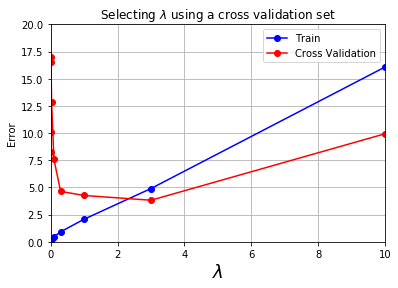

In [30]:
plt.plot(lambda_vec, error_train,'b-o', label='Train')
plt.plot(lambda_vec, error_val,'r-o', label='Cross Validation')
plt.xlabel(r'$\lambda$', fontsize=18)
plt.title('Selecting '+ r'$\lambda$ '+ 'using a cross validation set')
plt.ylabel('Error')
plt.axis([0,10,0,20])
plt.grid(True)
plt.legend(loc='best')
plt.show()

In the figure bove, we can see that the best value of $\lambda$ is around 3. Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.

### 3.4 - Optional (ungraded) exercise: Computing test set error

In the previous part of the exercise, you implemented code to compute the cross validation error for various values of the regularization parameter $\lambda$. However, to get a better indication of the model's performance in the real
world, it is important to evaluate the "final" model on a test set that was not used in any part of training (that is, it was neither used to select the $\lambda$ parameters, nor to learn the model parameters $\theta$.).

For this optional (ungraded) exercise, we are attempting to compute the test error using the best value of $\lambda$ we just found, $\lambda = 3$. To implement this, we train on `X_poly_train` and `y_train` using the best lambda $\lambda = 3$ found from Section 3.3. Then we measure $J_{test}$ on `X_poly_test` and `y_test`, **without regularization**. We dont regularize because we try to avoid regularizing twice!

In [31]:
theta = trainLinearReg(X_poly_train, y_train, Lambda=3); 
cost = linearRegCostFunction(X_poly_test, y_test, theta, Lambda=0);
print('The test error computed with theta found by training the model with Lambda = %d is %f' % (3,cost))

The test error computed with theta found by training the model with Lambda = 3 is 3.859888


### 3.5 - Optional (ungraded) exercise: Plotting learning curves with randomly selected examples

In practice, especially for small training sets, when we plot learning curves to debug our algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.

Concretely, to determine the training error and cross validation error for i examples, we should first randomly select i examples from the training set and i examples from the cross validation set. We will then learn the parameters $\theta$ using the randomly chosen training set and evaluate the parameters $\theta$ on the randomly chosen training set and cross validation set

The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error  i examples.

For this optional (ungraded) exercise, we shall implement the above strategy for computing the learning curves.

In [32]:
# INCOMPLETE